In [40]:
# imports necessary for this analysis
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from sklearn.feature_selection import RFECV
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.linear_model import LogisticRegression

**Data Exploration**

In [2]:
train = pd.read_csv('train.csv')
holdout = pd.read_csv('test.csv')

holdout.head()

PassengerId  Pclass                                          Name     Sex  \
0          892       3                              Kelly, Mr. James    male   
1          893       3              Wilkes, Mrs. James (Ellen Needs)  female   
2          894       2                     Myles, Mr. Thomas Francis    male   
3          895       3                              Wirz, Mr. Albert    male   
4          896       3  Hirvonen, Mrs. Alexander (Helga E Lindqvist)  female   

    Age  SibSp  Parch   Ticket     Fare Cabin Embarked  
0  34.5      0      0   330911   7.8292   NaN        Q  
1  47.0      1      0   363272   7.0000   NaN        S  
2  62.0      0      0   240276   9.6875   NaN        Q  
3  27.0      0      0   315154   8.6625   NaN        S  
4  22.0      1      1  3101298  12.2875   NaN        S

In [3]:
# %load functions.py
def process_missing(df):
    """Handle various missing values from the data set

    Usage
    ------

    holdout = process_missing(holdout)
    """
    df["Fare"] = df["Fare"].fillna(train["Fare"].mean())
    df["Embarked"] = df["Embarked"].fillna("S")
    return df

def process_age(df):
    """Process the Age column into pre-defined 'bins' 

    Usage
    ------

    train = process_age(train)
    """
    df["Age"] = df["Age"].fillna(-0.5)
    cut_points = [-1,0,5,12,18,35,60,100]
    label_names = ["Missing","Infant","Child","Teenager","Young Adult","Adult","Senior"]
    df["Age_categories"] = pd.cut(df["Age"],cut_points,labels=label_names)
    return df

def process_fare(df):
    """Process the Fare column into pre-defined 'bins' 

    Usage
    ------

    train = process_fare(train)
    """
    cut_points = [-1,12,50,100,1000]
    label_names = ["0-12","12-50","50-100","100+"]
    df["Fare_categories"] = pd.cut(df["Fare"],cut_points,labels=label_names)
    return df

def process_cabin(df):
    """Process the Cabin column into pre-defined 'bins' 

    Usage
    ------

    train process_cabin(train)
    """
    df["Cabin_type"] = df["Cabin"].str[0]
    df["Cabin_type"] = df["Cabin_type"].fillna("Unknown")
    df = df.drop('Cabin',axis=1)
    return df

def process_titles(df):
    """Extract and categorize the title from the name column 

    Usage
    ------

    train = process_titles(train)
    """
    titles = {
        "Mr" :         "Mr",
        "Mme":         "Mrs",
        "Ms":          "Mrs",
        "Mrs" :        "Mrs",
        "Master" :     "Master",
        "Mlle":        "Miss",
        "Miss" :       "Miss",
        "Capt":        "Officer",
        "Col":         "Officer",
        "Major":       "Officer",
        "Dr":          "Officer",
        "Rev":         "Officer",
        "Jonkheer":    "Royalty",
        "Don":         "Royalty",
        "Sir" :        "Royalty",
        "Countess":    "Royalty",
        "Dona":        "Royalty",
        "Lady" :       "Royalty"
    }
    extracted_titles = df["Name"].str.extract(' ([A-Za-z]+)\.',expand=False)
    df["Title"] = extracted_titles.map(titles)
    return df

def create_dummies(df,column_name):
    """Create Dummy Columns (One Hot Encoding) from a single Column

    Usage
    ------

    train = create_dummies(train,"Age")
    """
    dummies = pd.get_dummies(df[column_name],prefix=column_name)
    df = pd.concat([df,dummies],axis=1)
    return df

In [4]:
# Add column that contains total number of family members
train['NumFamMem'] = train['SibSp'] + train['Parch']
holdout['NumFamMem'] = holdout['SibSp'] + holdout['Parch']

def add_alone_col(df):
    df["isalone"] = np.where(df['NumFamMem'] > 0, 0, 1)
    return df

In [5]:
def pre_process_data(df):
    df = process_missing(df)
    df = process_age(df)
    df = process_fare(df)
    df = process_titles(df)
    df = process_cabin(df)
    df = create_dummies(df, 'Age_categories')
    df = create_dummies(df, 'Fare_categories')
    df = create_dummies(df, 'Title')
    df = create_dummies(df, 'Cabin_type')
    df = create_dummies(df, 'Sex')
    df = add_alone_col(df)
    return df

In [6]:
train = pre_process_data(train)
holdout = pre_process_data(holdout)

In [7]:
train[['SibSp', 'Parch']].dtypes

SibSp    int64
Parch    int64
dtype: object

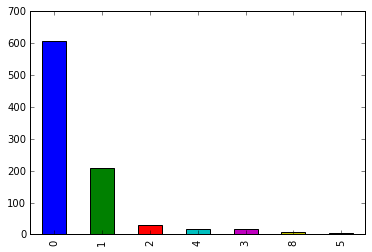

In [8]:
%matplotlib inline
train['SibSp'].value_counts().plot.bar()

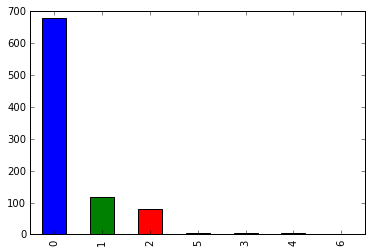

In [9]:
train['Parch'].value_counts().plot.bar()

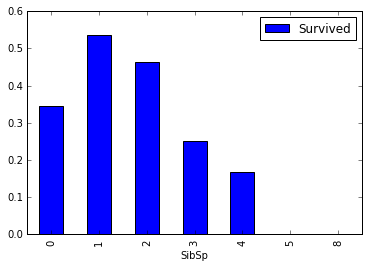

In [10]:
pclass_pivot = train.pivot_table(index="SibSp", values="Survived")
pclass_pivot.plot.bar()

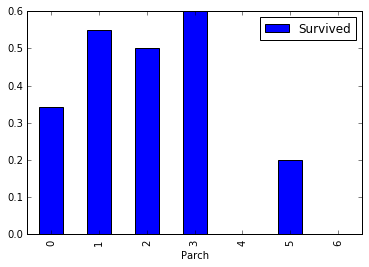

In [11]:
pclass_pivot = train.pivot_table(index="Parch", values="Survived")
pclass_pivot.plot.bar()

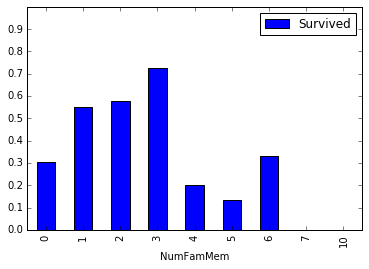

In [12]:
pclass_pivot = train.pivot_table(index="NumFamMem", values="Survived")
pclass_pivot.plot.bar(ylim=(0,1),yticks=np.arange(0,1,.1))

**Feature selection**

In [13]:
train.columns
train.head()

PassengerId  Survived  Pclass  \
0            1         0       3   
1            2         1       1   
2            3         1       3   
3            4         1       1   
4            5         0       3   

                                                Name     Sex   Age  SibSp  \
0                            Braund, Mr. Owen Harris    male  22.0      1   
1  Cumings, Mrs. John Bradley (Florence Briggs Th...  female  38.0      1   
2                             Heikkinen, Miss. Laina  female  26.0      0   
3       Futrelle, Mrs. Jacques Heath (Lily May Peel)  female  35.0      1   
4                           Allen, Mr. William Henry    male  35.0      0   

   Parch            Ticket     Fare   ...    Cabin_type_C  Cabin_type_D  \
0      0         A/5 21171   7.2500   ...               0             0   
1      0          PC 17599  71.2833   ...               1             0   
2      0  STON/O2. 3101282   7.9250   ...               0             0   
3      0            113803  53.1000   ...               1             0   
4      0            373450   8.0500   ...               0             0   

  Cabin_type_E Cabin_type_F Cabin_type_G Cabin_type_T  Cabin_type_Unknown  \
0            0            0            0            0                   1   
1            0            0            0            0                   0   
2            0            0            0            0                   1   
3            0            0            0            0                   0   
4            0            0            0            0                   1   

   Sex_female  Sex_male  isalone  
0           0         1        0  
1           1         0        0  
2           1         0        1  
3           1         0        0  
4           0         1        1  

[5 rows x 45 columns]

In [14]:
def select_features(df):
    df = df.dropna(axis = 1)
    df_non_numeric = df.select_dtypes(include='object')
    df = df.drop(df_non_numeric.columns, axis=1)
    df = df.drop(['Age_categories', 'Fare_categories'], axis = 1)
    all_X = df.loc[:, (df.columns != 'PassengerId') & (df.columns != 'Survived')]
    all_y = df['Survived']
    clf = RandomForestClassifier(random_state=1)
    selector = RFECV(clf, cv=10)
    selector.fit(all_X, all_y)
    optimized_columns = all_X.columns[selector.support_]
    print(optimized_columns)
    return optimized_columns
    

In [20]:
best_features = select_features(train)

Index(['Pclass', 'Age', 'SibSp', 'Parch', 'Fare', 'NumFamMem',
       'Age_categories_Missing', 'Age_categories_Infant',
       'Age_categories_Child', 'Age_categories_Teenager',
       'Age_categories_Young Adult', 'Age_categories_Adult',
       'Age_categories_Senior', 'Fare_categories_0-12',
       'Fare_categories_12-50', 'Fare_categories_50-100',
       'Fare_categories_100+', 'Title_Master', 'Title_Miss', 'Title_Mr',
       'Title_Mrs', 'Title_Officer', 'Cabin_type_A', 'Cabin_type_B',
       'Cabin_type_C', 'Cabin_type_D', 'Cabin_type_E', 'Cabin_type_F',
       'Cabin_type_G', 'Cabin_type_Unknown', 'Sex_female', 'Sex_male',
       'isalone'],
      dtype='object')


/dataquest/system/env/python3/lib/python3.4/site-packages/sklearn/utils/__init__.py:54: FutureWarning: Conversion of the second argument of issubdtype from `int` to `np.signedinteger` is deprecated. In future, it will be treated as `np.int64 == np.dtype(int).type`.
  if np.issubdtype(mask.dtype, np.int):


**Model Selection**

In [22]:
# Creting a list of dictionaries where each dictionary contains
# a model name, estimator and hyperparameters

logistic_regression = {
    "name": "LogisticRegression",
    "estimator": LogisticRegression(),
    "hyperparameters":
        {
            "solver": ["newton-cg", "lbfgs", "liblinear"]
        }
}

knn = {
    "name": "KNeighborsClassifier",
    "estimator": KNeighborsClassifier(),
    "hyperparameters":
        {
            "n_neighbors": range(1,20,2),
            "weights": ["distance", "uniform"],
            "algorithm": ["ball_tree", "kd_tree", "brute"],
            "p": [1,2]
        }
}

random_forest = {
    "name": "RandomForestClassifier",
    "estimator": RandomForestClassifier(),
    "hyperparameters":
        {
            "n_estimators": [4, 6, 9],
            "criterion": ["entropy", "gini"],
            "max_depth": [2, 5, 10],
            "max_features": ["log2", "sqrt"],
            "min_samples_leaf": [1, 5, 8],
            "min_samples_split": [2, 3, 5]
        }
}

model_list = [logistic_regression, knn, random_forest]

In [23]:
def select_model(df, features_list, model_list):
    all_X = df[features_list]
    all_y = df['Survived']
    
    for model in model_list:
        print('Running ', model['name'])
        grid = GridSearchCV(model['estimator'], param_grid=model['hyperparameters'], cv=10)
        grid.fit(all_X, all_y) 
        model['best_params'] = grid.best_params_
        model['best_score'] = grid.best_score_
        model['best_est'] = grid.best_estimator_
        print(model['best_params'])
        print(model['best_score'])
        
    return model_list

In [27]:
best_models = select_model(train, best_features, model_list)

Running  LogisticRegression
{'solver': 'lbfgs'}
0.8204264870931538
Running  KNeighborsClassifier
{'algorithm': 'kd_tree', 'weights': 'uniform', 'p': 1, 'n_neighbors': 3}
0.7800224466891134
Running  RandomForestClassifier
{'min_samples_leaf': 1, 'criterion': 'entropy', 'n_estimators': 9, 'max_depth': 10, 'min_samples_split': 2, 'max_features': 'log2'}
0.8361391694725028


In [28]:
def save_submission_file(trained_model, selected_features, file_name = 'submission.csv'):
    holdout_predictions = trained_model.predict(holdout[selected_features])
    submission_dict = {'PassengerId': holdout['PassengerId'], 'Survived': holdout_predictions}
    submission_df = pd.DataFrame(submission_dict)
    submission_df.to_csv(file_name, index = False)

In [51]:
# Select the best model based on the model's score
model_max_score = max([model['best_score'] for model in best_models])
i = [i for i, j in enumerate([model['best_score'] for model in best_models]) if j == model_max_score]
print(type(best_models[i[]]))
#selected_model = best_models[i[0]['best_est']] # i is a list of one element due to list comprehension


<class 'list'>


In [43]:
# Run best model and crete a submission file
save_submission_file(selected_model, best_features)

AttributeError: 'dict' object has no attribute 'predict'